# Data Analytics Pipeline for Credit Card Transactions

### Install Necessary Packages
This section covers the installation of required libraries like `pandas`, `geopandas`, `matplotlib`, and others.

In [1]:
## Install necessary packages (only run this in Jupyter if packages are not installed)
!pip install hvplot geopandas pandas matplotlib seaborn numpy plotly

### Import Dependencies
Standard Python libraries used for data manipulation, time series analysis, and visualization.

In [2]:
# Importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
import hvplot.pandas  # For interactive visualizations
from datetime import datetime
from pathlib import Path

### Create an output directory to save graphs

In [3]:
# Create 'AK_Output' directory if it doesn't exist
output_dir = Path('AK_Output')
output_dir.mkdir(exist_ok=True)

### Data Ingestion
Loading the data from `credit_card_transactions.csv` and checking the initial few rows.

In [4]:
# Read the CSV file into a dataframe
data = pd.read_csv('credit_card_transactions.csv')

# Display the first few records
data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0


### Exploratory Data Analysis (EDA)
Exploring key data characteristics, such as transaction categories, states, and data types.

In [5]:
# Explore data columns
data.info()

# Display unique categories in 'category' column
unique_category = data['category'].unique()
print(f"Unique Categories: {unique_category}")

# Display unique states in 'state' column
unique_states = data['state'].unique()
print(f"Number of Unique States: {len(unique_states)}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

### Data Cleaning
Cleaning and preprocessing the dataset by removing unnecessary columns and converting date columns.

In [6]:
# Make a copy for transformation
ak_df = data.copy()

# Convert date columns to datetime format
ak_df['trans_date_trans_time'] = pd.to_datetime(ak_df['trans_date_trans_time'])
ak_df['dob'] = pd.to_datetime(ak_df['dob'])

# Drop unnecessary columns
columns_to_drop = [
    'Unnamed: 0', 'first', 'last', 'street', 'lat', 'long', 'merch_zipcode',
    'merch_lat', 'merch_long', 'trans_num', 'unix_time', 'is_fraud', 'zip'
]
ak_df_cleaned = ak_df.drop(columns=columns_to_drop)

# Check for null values
print(ak_df_cleaned.isnull().sum())

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
gender                   0
city                     0
state                    0
city_pop                 0
job                      0
dob                      0
dtype: int64


### Feature Engineering
Creating new features like `time_of_day`, `age_group`, and calculating recency for transaction analysis.

In [7]:
# Categorize time of day based on transaction hour
ak_df_cleaned['time_of_day'] = ak_df_cleaned['trans_date_trans_time'].dt.hour.apply(
    lambda hour: 'Morning' if 6 <= hour < 12 else
    ('Afternoon' if 12 <= hour < 18 else
    ('Evening' if 18 <= hour < 24 else 'Night'))
)

# Calculate age based on DOB and transaction year
ak_df_cleaned['age'] = ak_df_cleaned['trans_date_trans_time'].dt.year - ak_df_cleaned['dob'].dt.year

# Define age segments
def age_segment(age):
    if age < 18:
        return 'Under 18'
    elif 19 <= age <= 28:
        return '19-28'
    elif 29 <= age <= 38:
        return '29-38'
    elif 39 <= age <= 48:
        return '39-48'
    elif 49 <= age <= 58:
        return '49-58'
    elif 59 <= age <= 68:
        return '59-68'
    elif 69 <= age <= 78:
        return '69-78'
    else:
        return '79+'

# Apply age segmentation
ak_df_cleaned['age_group'] = ak_df_cleaned['age'].apply(age_segment)

ak_df_cleaned.head()

,trans_date_trans_time,cc_num,merchant,category,amt,gender,city,state,city_pop,job,dob,time_of_day,age,age_group
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,Moravian Falls,NC,3495,"Psychologist, counselling",1988-03-09,Night,31,29-38
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,Orient,WA,149,Special educational needs teacher,1978-06-21,Night,41,39-48
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,M,Malad City,ID,4154,Nature conservation officer,1962-01-19,Night,57,49-58
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,Boulder,MT,1939,Patent attorney,1967-01-12,Night,52,49-58
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,M,Doe Hill,VA,99,Dance movement psychotherapist,1986-03-28,Night,33,29-38


### Explorations After Transformation
Exploring new insights based on the cleaned and transformed data.

In [8]:
# Find the transaction date range
date_range = (ak_df_cleaned['trans_date_trans_time'].min(), ak_df_cleaned['trans_date_trans_time'].max())
print(f"Transaction date range: {date_range[0].date()} to {date_range[1].date()}")

# Count unique credit card numbers
unique_cc_numbers = ak_df_cleaned['cc_num'].nunique()
print(f"Number of unique credit card numbers: {unique_cc_numbers}")

# Gender distribution
gender_counts = ak_df_cleaned['gender'].value_counts()
print(f"Gender Distribution:\n{gender_counts}")

# Find the minimum and maximum age in the cleaned dataset
min_age = ak_df_cleaned['age'].min()
max_age = ak_df_cleaned['age'].max()
print(f"Minimum age of users: {min_age}")
print(f"Maximum age of users: {max_age}")

Transaction date range: 2019-01-01 to 2020-06-21
Number of unique credit card numbers: 983
Gender Distribution:
gender
F    709863
M    586812
Name: count, dtype: int64
Minimum age of users: 14
Maximum age of users: 96


### Visualization to understand current customer segmentation
Visualizing trends, customer segmentation

### Month-to-Month Monthly transaction 

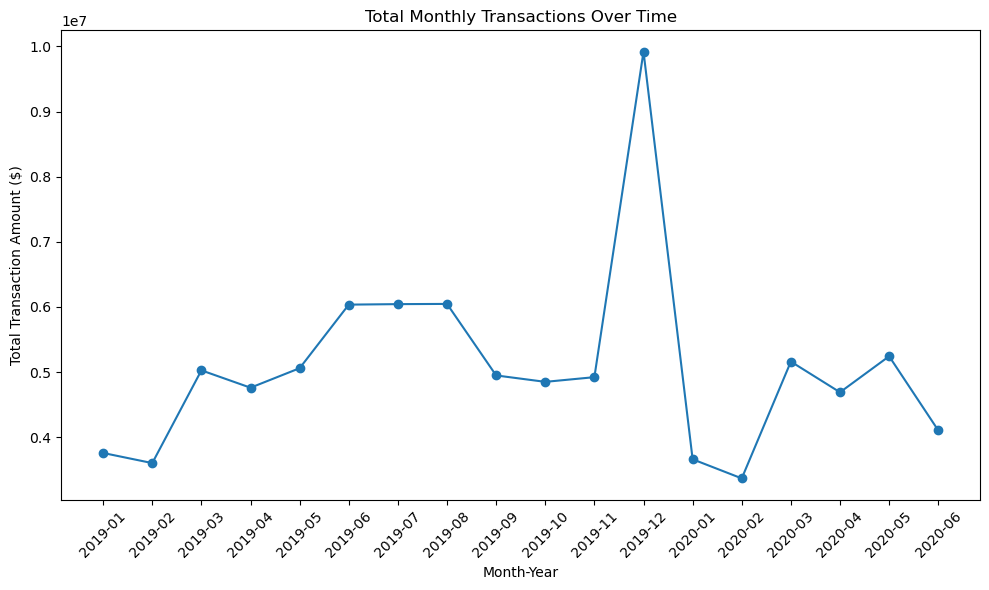

In [9]:
# Visualization: Monthly Transaction Amounts
monthly_transaction = ak_df_cleaned.groupby(
    [ak_df_cleaned['trans_date_trans_time'].dt.to_period('M')]
)['amt'].sum().reset_index()

# Plot using matplotlib
plt.figure(figsize=(10, 6))
plt.plot(monthly_transaction['trans_date_trans_time'].astype(str), monthly_transaction['amt'], marker='o')
plt.title('Total Monthly Transactions Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Total Transaction Amount ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(output_dir / 'monthly_transactions.png')
plt.show()

#### Total Transaction by Age Group

/var/folders/x3/vr0xk6j11ll6hgm_xsz_5cn00000gn/T/ipykernel_136/2196950866.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='age_group', y='amt', data=age_group_transaction, palette='viridis')


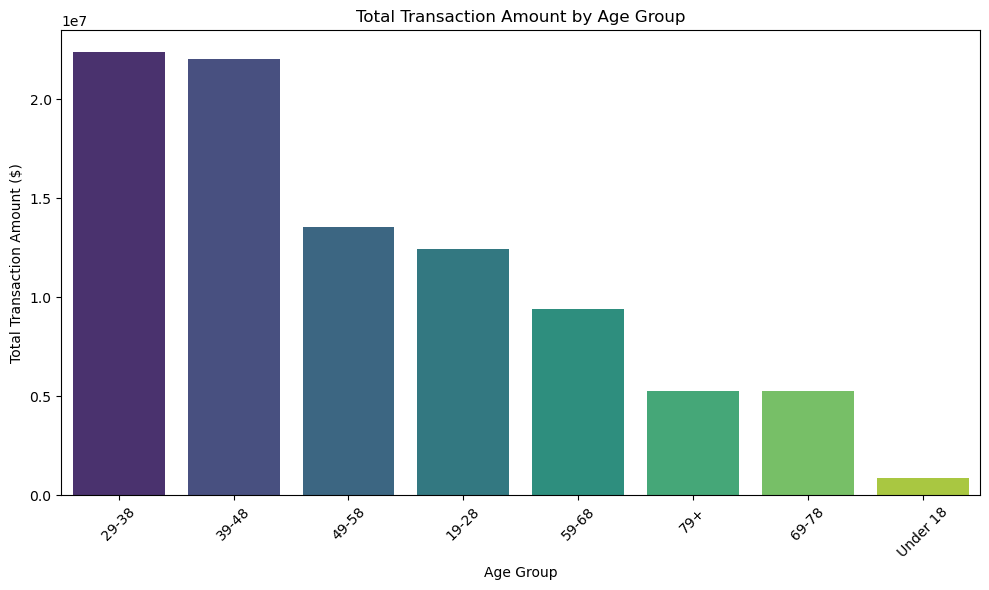

In [10]:
# Group transactions by age group and sum the amounts
age_group_transaction = ak_df_cleaned.groupby('age_group')['amt'].sum().reset_index()

# Sort the age groups by transaction amount in descending order
age_group_transaction = age_group_transaction.sort_values(by='amt', ascending=False)

# Bar plot for total transactions by age group
plt.figure(figsize=(10, 6))
sns.barplot(x='age_group', y='amt', data=age_group_transaction, palette='viridis')
plt.title('Total Transaction Amount by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Total Transaction Amount ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(output_dir / 'transactions_by_age_group.png')
plt.show()

### Total Transaction by State

/var/folders/x3/vr0xk6j11ll6hgm_xsz_5cn00000gn/T/ipykernel_136/446760962.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='state', y='amt', data=state_transaction, palette='plasma')


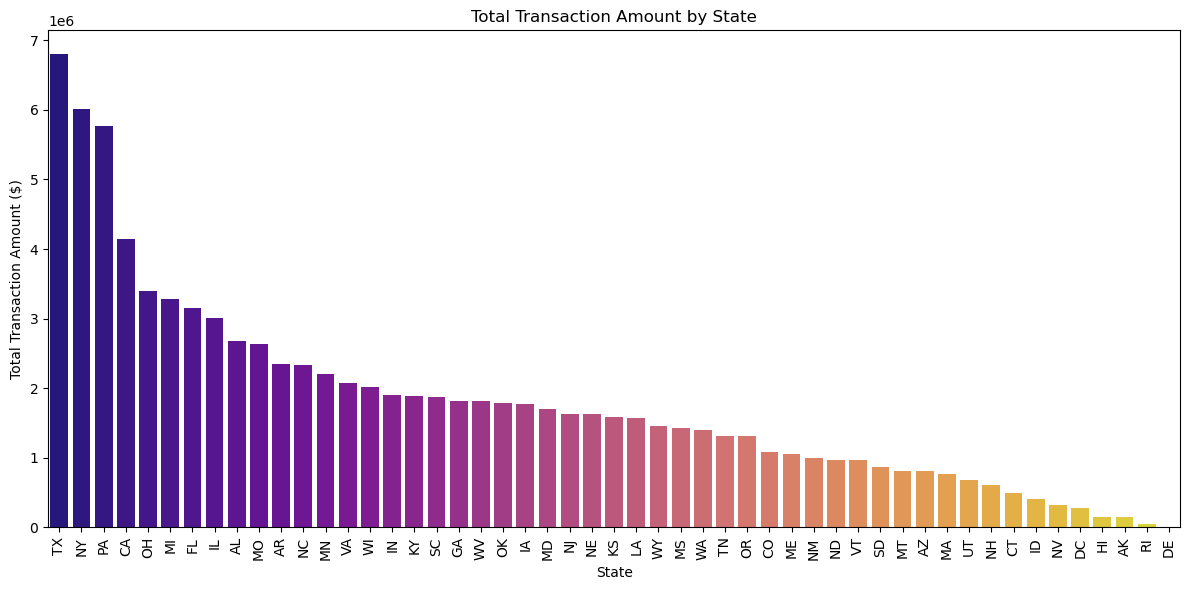

In [12]:
# Group transactions by state and sum the amounts
state_transaction = ak_df_cleaned.groupby('state')['amt'].sum().reset_index()

# Sort the states by transaction amount in descending order
state_transaction = state_transaction.sort_values(by='amt', ascending=False)

# Bar plot for total transactions by state
plt.figure(figsize=(12, 6))
sns.barplot(x='state', y='amt', data=state_transaction, palette='plasma')
plt.title('Total Transaction Amount by State')
plt.xlabel('State')
plt.ylabel('Total Transaction Amount ($)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(output_dir / 'transactions_by_state.png')
plt.show()

### Total and Average Transaction by Category

/var/folders/x3/vr0xk6j11ll6hgm_xsz_5cn00000gn/T/ipykernel_136/2372001111.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='category', y='amt', data=category_total_transaction, palette='coolwarm', ax=ax1)
/var/folders/x3/vr0xk6j11ll6hgm_xsz_5cn00000gn/T/ipykernel_136/2372001111.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='category', y='amt', data=category_avg_transaction, palette='coolwarm', ax=ax2)


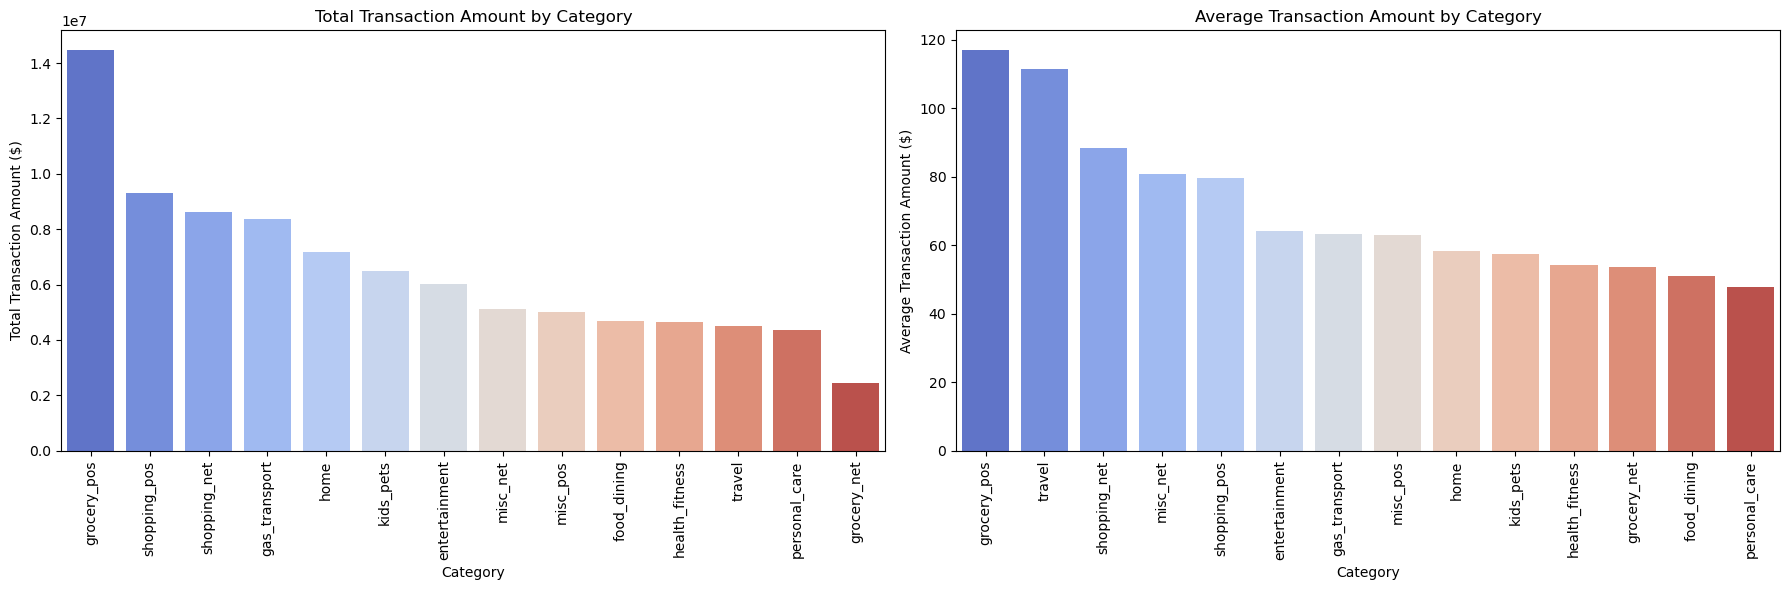

In [13]:
# Group transactions by category and calculate total and average amounts
category_total_transaction = ak_df_cleaned.groupby('category')['amt'].sum().reset_index()
category_avg_transaction = ak_df_cleaned.groupby('category')['amt'].mean().reset_index()

# Sort categories by total transaction amount in descending order for the first plot
category_total_transaction = category_total_transaction.sort_values(by='amt', ascending=False)

# Sort categories by average transaction amount in descending order for the second plot
category_avg_transaction = category_avg_transaction.sort_values(by='amt', ascending=False)

# Create subplots for both graphs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot total transaction amount by category
sns.barplot(x='category', y='amt', data=category_total_transaction, palette='coolwarm', ax=ax1)
ax1.set_title('Total Transaction Amount by Category')
ax1.set_xlabel('Category')
ax1.set_ylabel('Total Transaction Amount ($)')
ax1.tick_params(axis='x', rotation=90)

# Plot average transaction amount by category
sns.barplot(x='category', y='amt', data=category_avg_transaction, palette='coolwarm', ax=ax2)
ax2.set_title('Average Transaction Amount by Category')
ax2.set_xlabel('Category')
ax2.set_ylabel('Average Transaction Amount ($)')
ax2.tick_params(axis='x', rotation=90)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig(output_dir / 'transactions_by_category.png')
plt.show()

### Total Number of Transaction and Total Transaction Amount by Time of Day

/var/folders/x3/vr0xk6j11ll6hgm_xsz_5cn00000gn/T/ipykernel_136/1845834733.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='time_of_day', y='count', data=time_of_day_transaction_count, palette='magma', ax=ax1)
/var/folders/x3/vr0xk6j11ll6hgm_xsz_5cn00000gn/T/ipykernel_136/1845834733.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='time_of_day', y='amt', data=time_of_day_transaction_amount, palette='magma', ax=ax2)


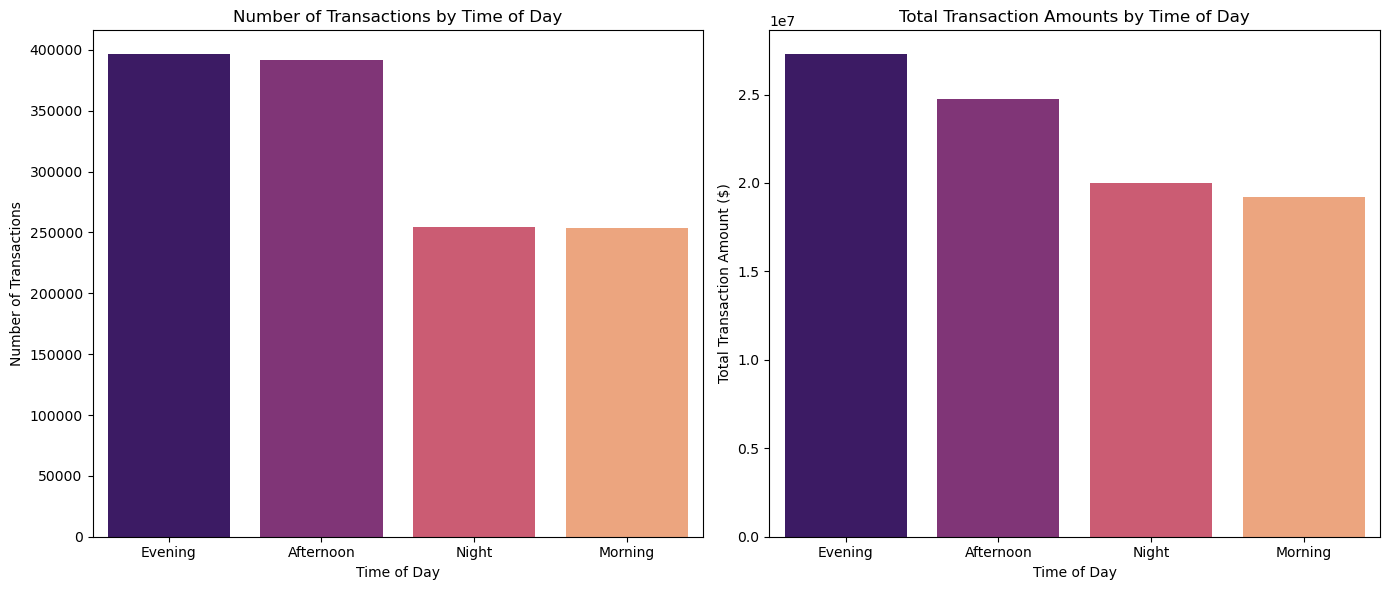

In [14]:
# Count transactions by time of day
time_of_day_transaction_count = ak_df_cleaned['time_of_day'].value_counts().reset_index()
time_of_day_transaction_count.columns = ['time_of_day', 'count']
# Sort transaction counts in descending order
time_of_day_transaction_count = time_of_day_transaction_count.sort_values(by='count', ascending=False)

# Sum transaction amounts by time of day
time_of_day_transaction_amount = ak_df_cleaned.groupby('time_of_day')['amt'].sum().reset_index()
# Sort transaction amounts in descending order
time_of_day_transaction_amount = time_of_day_transaction_amount.sort_values(by='amt', ascending=False)

# Create subplots for both graphs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot transaction counts by time of day
sns.barplot(x='time_of_day', y='count', data=time_of_day_transaction_count, palette='magma', ax=ax1)
ax1.set_title('Number of Transactions by Time of Day')
ax1.set_xlabel('Time of Day')
ax1.set_ylabel('Number of Transactions')

# Plot total transaction amounts by time of day
sns.barplot(x='time_of_day', y='amt', data=time_of_day_transaction_amount, palette='magma', ax=ax2)
ax2.set_title('Total Transaction Amounts by Time of Day')
ax2.set_xlabel('Time of Day')
ax2.set_ylabel('Total Transaction Amount ($)')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig(output_dir / 'transactions_by_time_of_day.png')
plt.show()

### Total Transaction by Gender

/var/folders/x3/vr0xk6j11ll6hgm_xsz_5cn00000gn/T/ipykernel_136/3717385381.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='gender', y='amt', data=gender_transaction, palette='pastel')


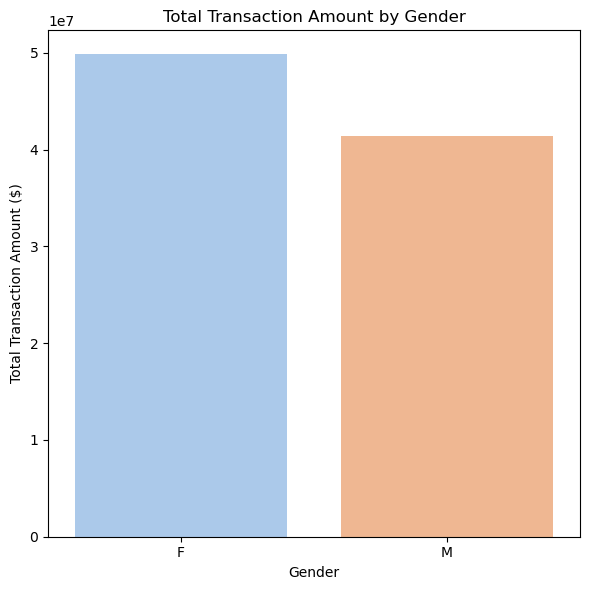

In [22]:
# Group transactions by gender and sum the amounts
gender_transaction = ak_df_cleaned.groupby('gender')['amt'].sum().reset_index()

# Bar plot for total transactions by gender
plt.figure(figsize=(6, 6))
sns.barplot(x='gender', y='amt', data=gender_transaction, palette='pastel')
plt.title('Total Transaction Amount by Gender')
plt.xlabel('Gender')
plt.ylabel('Total Transaction Amount ($)')
plt.tight_layout()
plt.savefig(output_dir / 'transactions_by_gender.png')
plt.show()

### Average Transaction Amount by Gender and Day of the Week

In [23]:
# Add a new column 'day_of_week' to represent the day of the week (0=Monday, 6=Sunday)
ak_df_cleaned['day_of_week'] = ak_df_cleaned['trans_date_trans_time'].dt.day_name()

In [24]:
# Group by 'gender' and 'day_of_week' and calculate the average transaction amount
gender_day_avg_transaction = ak_df_cleaned.groupby(['gender', 'day_of_week'])['amt'].mean().reset_index()

# Sort days of the week for proper ordering
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
gender_day_avg_transaction['day_of_week'] = pd.Categorical(gender_day_avg_transaction['day_of_week'], categories=day_order, ordered=True)
gender_day_avg_transaction = gender_day_avg_transaction.sort_values('day_of_week')

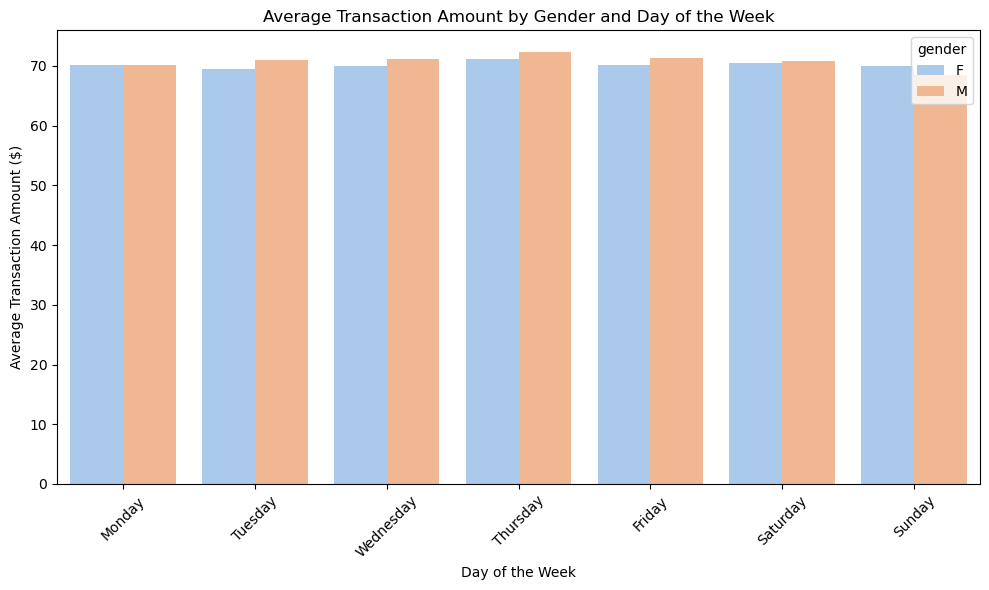

In [25]:
# Bar plot for average transactions by gender and day of the week
plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='amt', hue='gender', data=gender_day_avg_transaction, palette='pastel')
plt.title('Average Transaction Amount by Gender and Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Transaction Amount ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Average Transaction by Gender by Time and Day

In [26]:
# Add a new column 'day_of_week' to represent the day of the week (0=Monday, 6=Sunday)
ak_df_cleaned['day_of_week'] = ak_df_cleaned['trans_date_trans_time'].dt.day_name()

# Group by 'gender', 'day_of_week', and 'time_of_day' and calculate the average transaction amount
gender_day_time_avg_transaction = (
    ak_df_cleaned.groupby(['gender', 'day_of_week', 'time_of_day'])['amt']
    .mean()
    .reset_index()
)

# Sort days of the week for proper ordering
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
gender_day_time_avg_transaction['day_of_week'] = pd.Categorical(
    gender_day_time_avg_transaction['day_of_week'],
    categories=day_order,
    ordered=True
)

# Sort time of day for proper ordering
time_of_day_order = ['Morning', 'Afternoon', 'Evening', 'Night']
gender_day_time_avg_transaction['time_of_day'] = pd.Categorical(
    gender_day_time_avg_transaction['time_of_day'],
    categories=time_of_day_order,
    ordered=True
)

# Sort the dataframe by 'day_of_week' and 'time_of_day'
gender_day_time_avg_transaction = gender_day_time_avg_transaction.sort_values(['day_of_week', 'time_of_day'])

/var/folders/x3/vr0xk6j11ll6hgm_xsz_5cn00000gn/T/ipykernel_136/868312828.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = gender_day_time_avg_transaction.pivot_table(


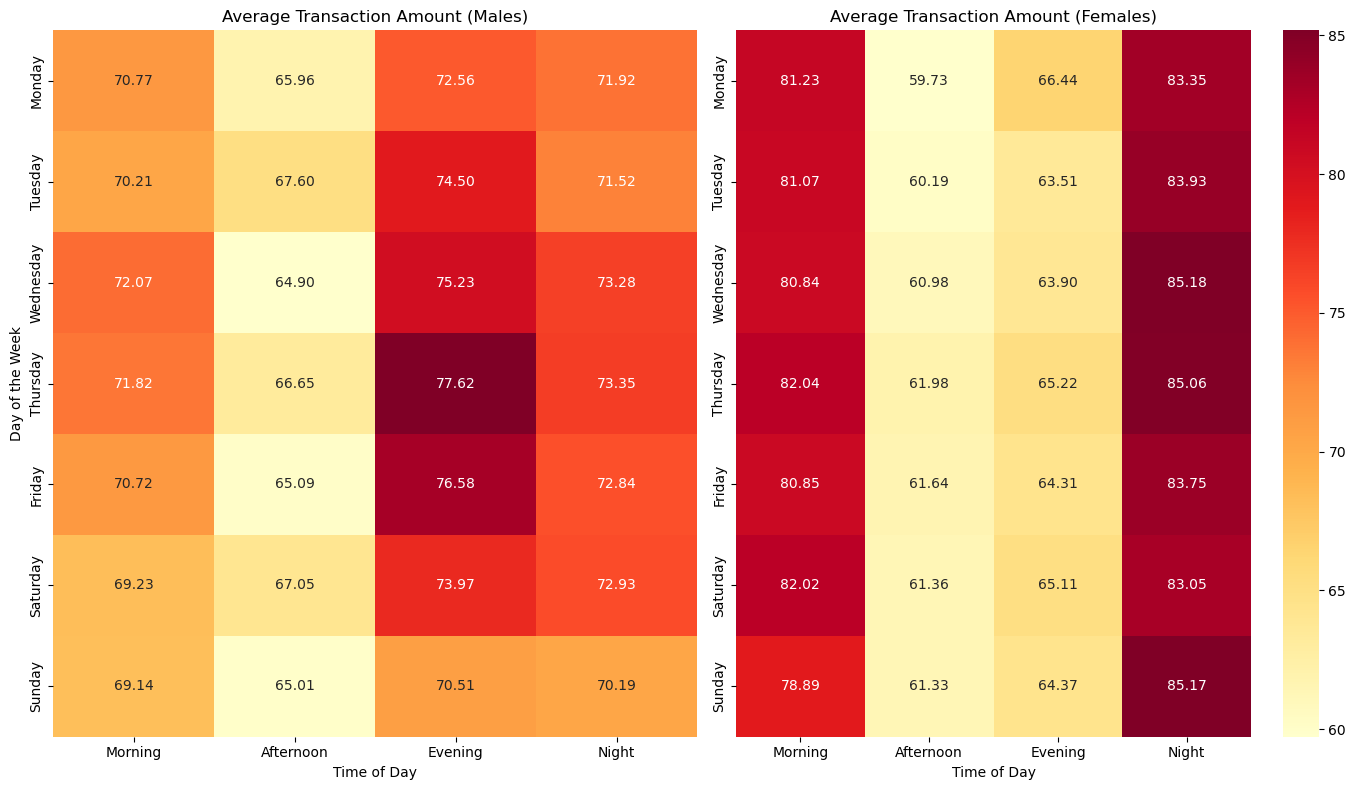

In [27]:
# Pivot the data for heatmap visualization
pivot_table = gender_day_time_avg_transaction.pivot_table(
    values='amt',
    index=['day_of_week', 'time_of_day'],
    columns='gender',
    fill_value=0
)

# Create a heatmap for males and females side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

# Heatmap for average transaction amounts by day and time of day for males
sns.heatmap(
    pivot_table['M'].unstack(),
    cmap='YlOrRd',
    ax=ax1,
    annot=True,
    fmt='.2f',
    cbar=False
)
ax1.set_title('Average Transaction Amount (Males)')
ax1.set_xlabel('Time of Day')
ax1.set_ylabel('Day of the Week')

# Heatmap for average transaction amounts by day and time of day for females
sns.heatmap(
    pivot_table['F'].unstack(),
    cmap='YlOrRd',
    ax=ax2,
    annot=True,
    fmt='.2f'
)
ax2.set_title('Average Transaction Amount (Females)')
ax2.set_xlabel('Time of Day')
ax2.set_ylabel('')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig(output_dir / 'heatmap_transactions_by_time_and_gender.png')
plt.show()

### Total Transaction by Job Category

In [28]:
# Define lists for each job category
education_training = [
    'Special educational needs teacher', 'Teacher, secondary school', 
    'Teacher, early years/pre', 'Teacher, primary school', 
    'Lecturer, further education', 'Lecturer, higher education', 
    'Education officer, community', 'Professor', 
    'Training and development officer', 'Educational psychologist', 
    'Adult education teacher'
]

healthcare_medicine = [
    'Doctor, hospital', 'Physiotherapist', 'Nurse, mental health', 
    'Radiographer, diagnostic', 'Paramedic', 'Clinical biochemist', 
    'Pharmacist, hospital', 'Surgeon', 'Radiographer, therapeutic', 
    'Psychiatrist', 'Clinical scientist', 'Community pharmacist'
]

engineering = [
    'Civil engineer, contracting', 'Mechanical engineer', 
    'Electrical engineer', 'Structural engineer', 'Aeronautical engineer', 
    'Biomedical engineer', 'Engineer, production', 'Mining engineer',
    'Electronics engineer', 'Systems engineer'
]

law_legal_services = [
    'Solicitor', 'Barrister', 'Patent attorney', 
    'Legal secretary', 'Chartered legal executive (England and Wales)', 
    'Legal assistant', 'Paralegal', 'Attorney'
]

finance_banking = [
    'Investment banker, corporate', 'Accountant, chartered', 
    'Financial adviser', 'Auditor', 'Tax adviser', 
    'Insurance broker', 'Financial trader', 'Investment analyst', 
    'Corporate investment banker', 'Actuary'
]

it_technology = [
    'Software developer', 'Data scientist', 'IT consultant', 
    'Network engineer', 'Systems analyst', 'Web designer', 
    'Database administrator', 'Cyber security analyst', 
    'Applications developer', 'IT trainer'
]

creative_design = [
    'Graphic designer', 'Multimedia designer', 'Video editor', 
    'Illustrator', 'Animator', 'Set designer', 'Interior designer', 
    'Exhibition designer', 'Fashion designer', 'Product designer'
]

marketing_advertising = [
    'Marketing executive', 'Advertising copywriter', 
    'PR officer', 'Brand manager', 'Media planner', 
    'Market researcher', 'Social media manager', 'Sales promotion account executive'
]

human_resources = [
    'HR manager', 'Recruitment consultant', 
    'Training and development officer', 'Personnel officer', 
    'Employee relations officer'
]

public_sector_government = [
    'Civil Service administrator', 'Local government officer', 
    'Policy advisor', 'Social research officer', 'Public affairs consultant'
]

arts_culture = [
    'Artist', 'Curator', 'Museum/gallery manager', 
    'Cultural heritage officer', 'Exhibition designer', 
    'Art gallery manager', 'Theatre director'
]

science_research = [
    'Research scientist', 'Biochemist', 'Physicist', 
    'Chemist', 'Geneticist', 'Clinical research associate', 
    'Research officer', 'Environmental scientist', 
    'Molecular biologist', 'Analytical chemist'
]

media_broadcasting = [
    'Journalist', 'Radio producer', 'TV presenter', 
    'Film producer', 'Broadcast engineer', 'News anchor', 
    'Media producer', 'Broadcast journalist'
]

construction_architecture = [
    'Architect', 'Building surveyor', 'Construction manager', 
    'Quantity surveyor', 'Site engineer', 'Structural engineer', 
    'Urban planner'
]

social_community_services = [
    'Social worker', 'Counsellor', 'Charity officer', 
    'Community development worker', 'Probation officer', 
    'Volunteer coordinator', 'Youth worker'
]

environmental_agricultural = [
    'Environmental scientist', 'Ecologist', 'Agricultural consultant', 
    'Hydrologist', 'Conservation officer', 'Horticulturist', 
    'Wildlife conservationist', 'Forestry manager'
]

logistics_supply_chain = [
    'Logistics manager', 'Warehouse manager', 
    'Freight forwarder', 'Supply chain analyst', 
    'Transport planner', 'Distribution manager'
]

sales_customer_service = [
    'Sales executive', 'Account manager', 'Call center manager', 
    'Customer service manager', 'Retail manager', 
    'Sales representative'
]

hospitality_tourism = [
    'Hotel manager', 'Travel agent', 'Tour guide', 
    'Event organizer', 'Restaurant manager', 
    'Tourism officer'
]

sports_fitness = [
    'Fitness trainer', 'Sports coach', 'Physiotherapist', 
    'Sports development officer', 'Personal trainer'
]

therapy_counseling = [
    'Art therapist', 'Music therapist', 
    'Occupational therapist', 'Psychotherapist', 
    'Counseling psychologist'
]

security_defense = [
    'Police officer', 'Armed forces officer', 
    'Security consultant', 'Prison officer', 
    'Firefighter'
]

real_estate_property = [
    'Real estate agent', 'Property manager', 
    'Estate manager', 'Quantity surveyor', 
    'Land surveyor'
]

manufacturing_production = [
    'Production manager', 'Manufacturing engineer', 
    'Product designer', 'Industrial designer', 
    'Quality control inspector'
]

retail_merchandising = [
    'Retail buyer', 'Visual merchandiser', 
    'Retail merchandiser', 'Store manager', 
    'Merchandise planner'
]

writing_editing = [
    'Writer', 'Editor', 'Copywriter', 
    'Commissioning editor', 'Magazine journalist'
]

chemistry_pharmaceuticals = [
    'Pharmacologist', 'Biochemist', 
    'Analytical chemist', 'Chemical engineer', 
    'Pharmacy technician'
]

transportation_aviation = [
    'Pilot', 'Transport planner', 
    'Air traffic controller', 'Cabin crew', 
    'Logistics coordinator'
]

executive_leadership = [
    'Chief Executive Officer', 'Chief Financial Officer', 
    'Chief Operating Officer', 'Chief Technology Officer', 
    'Director', 'Chief Marketing Officer', 
    'Chief Strategy Officer'
]

miscellaneous = [
    'Barista', 'Homeopath', 'Dancer', 
    'Unique roles not categorized elsewhere'
]

# Combine all category lists into a dictionary using dictionary comprehensions
job_category_mapping = {
    **{job: 'Education & Training' for job in education_training},
    **{job: 'Healthcare & Medicine' for job in healthcare_medicine},
    **{job: 'Engineering' for job in engineering},
    **{job: 'Law & Legal Services' for job in law_legal_services},
    **{job: 'Finance & Banking' for job in finance_banking},
    **{job: 'IT & Technology' for job in it_technology},
    **{job: 'Creative & Design' for job in creative_design},
    **{job: 'Marketing & Advertising' for job in marketing_advertising},
    **{job: 'Human Resources' for job in human_resources},
    **{job: 'Public Sector & Government' for job in public_sector_government},
    **{job: 'Arts & Culture' for job in arts_culture},
    **{job: 'Science & Research' for job in science_research},
    **{job: 'Media & Broadcasting' for job in media_broadcasting},
    **{job: 'Construction & Architecture' for job in construction_architecture},
    **{job: 'Social & Community Services' for job in social_community_services},
    **{job: 'Environmental & Agricultural' for job in environmental_agricultural},
    **{job: 'Logistics & Supply Chain' for job in logistics_supply_chain},
    **{job: 'Sales & Customer Service' for job in sales_customer_service},
    **{job: 'Hospitality & Tourism' for job in hospitality_tourism},
    **{job: 'Sports & Fitness' for job in sports_fitness},
    **{job: 'Therapy & Counseling' for job in therapy_counseling},
    **{job: 'Security & Defense' for job in security_defense},
    **{job: 'Real Estate & Property' for job in real_estate_property},
    **{job: 'Manufacturing & Production' for job in manufacturing_production},
    **{job: 'Retail & Merchandising' for job in retail_merchandising},
    **{job: 'Writing & Editing' for job in writing_editing},
    **{job: 'Chemistry & Pharmaceuticals' for job in chemistry_pharmaceuticals},
    **{job: 'Transportation & Aviation' for job in transportation_aviation},
    **{job: 'Executive Leadership' for job in executive_leadership},
    **{job: 'Miscellaneous' for job in miscellaneous}
}

# Map the jobs to their respective categories
ak_df_cleaned['job_category'] = ak_df_cleaned['job'].map(job_category_mapping).fillna('Miscellaneous')

# Display the first few rows to verify the mapping
ak_df_cleaned[['job', 'job_category']].head(10)

,job,job_category
0,"Psychologist, counselling",Miscellaneous
1,Special educational needs teacher,Education & Training
2,Nature conservation officer,Miscellaneous
3,Patent attorney,Law & Legal Services
4,Dance movement psychotherapist,Miscellaneous
5,Transport planner,Transportation & Aviation
6,Arboriculturist,Miscellaneous
7,"Designer, multimedia",Miscellaneous
8,Public affairs consultant,Public Sector & Government
9,Pathologist,Miscellaneous


/var/folders/x3/vr0xk6j11ll6hgm_xsz_5cn00000gn/T/ipykernel_136/4149477254.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='amt', y='job_category', data=job_category_transaction, palette='viridis')


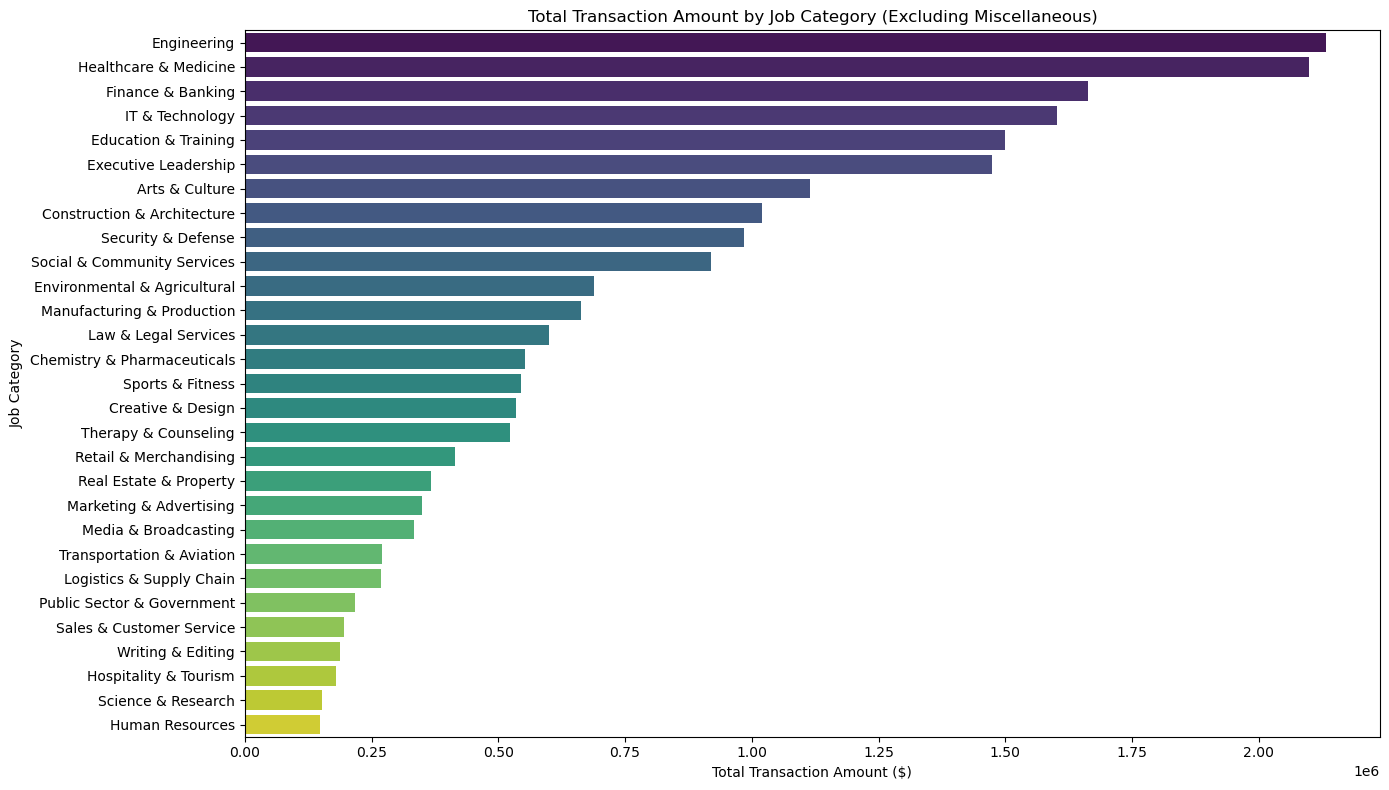

In [29]:
# Visualization without Miscellaneous as it is a huge category

# Group transactions by job category and sum the amounts
job_category_transaction = ak_df_cleaned.groupby('job_category')['amt'].sum().reset_index()

# Filter out the 'Miscellaneous' category
job_category_transaction = job_category_transaction[job_category_transaction['job_category'] != 'Miscellaneous']

# Sort job categories by total transaction amount in descending order
job_category_transaction = job_category_transaction.sort_values(by='amt', ascending=False)

# Create a bar plot for total transaction amount by job category
plt.figure(figsize=(14, 8))
sns.barplot(x='amt', y='job_category', data=job_category_transaction, palette='viridis')
plt.title('Total Transaction Amount by Job Category (Excluding Miscellaneous)')
plt.xlabel('Total Transaction Amount ($)')
plt.ylabel('Job Category')
plt.tight_layout()
plt.savefig(output_dir / 'transactions_by_job_category.png')
plt.show()

## Defining a Customer Loyalty Segment
- The following section defines Customer Loyalty based on transaction frequency, recency, average transaction amount

 ### Key Metrics: recency_days

In [30]:
# Group by customer (cc_num) and calculate key metrics
customer_metrics = ak_df_cleaned.groupby('cc_num').agg(
    transaction_count=('amt', 'count'),  # Number of transactions (Frequency)
    total_spend=('amt', 'sum'),          # Total spending
    avg_transaction_amt=('amt', 'mean'), # Average transaction amount
    last_transaction=('trans_date_trans_time', 'max')  # Date of the last transaction (Recency)
).reset_index()

# Calculate recency as the difference in days between the last transaction and a reference date (latest transaction date + 1 day)
reference_date = customer_metrics['last_transaction'].max() + pd.Timedelta(days=1)
customer_metrics['recency_days'] = (reference_date - customer_metrics['last_transaction']).dt.days

# Display the calculated metrics for customers
customer_metrics.head()

,cc_num,transaction_count,total_spend,avg_transaction_amt,last_transaction,recency_days
0,60416207185,1518,85043.47,56.023366,2020-06-21 08:54:21,1
1,60422928733,1531,105640.20,69.000784,2020-06-21 09:19:28,1
2,60423098130,510,58673.63,115.046333,2020-06-19 01:14:31,3
3,60427851591,528,59129.61,111.987898,2020-06-19 13:06:04,2
4,60487002085,496,25160.11,50.726028,2020-06-20 15:44:36,1


### Key Metrics: thresholds for frequency, recency and average amount

In [31]:
# Define thresholds for segmentation using quantiles
frequency_thresholds = customer_metrics['transaction_count'].quantile([0.25, 0.5, 0.75])
recency_thresholds = customer_metrics['recency_days'].quantile([0.25, 0.5, 0.75])
avg_amt_thresholds = customer_metrics['avg_transaction_amt'].quantile([0.25, 0.5, 0.75])

# Function to classify transaction frequency
def classify_frequency(x):
    if x <= frequency_thresholds[0.25]:
        return 'Low Frequency'
    elif frequency_thresholds[0.25] < x <= frequency_thresholds[0.5]:
        return 'Moderate Frequency'
    elif frequency_thresholds[0.5] < x <= frequency_thresholds[0.75]:
        return 'High Frequency'
    else:
        return 'Very High Frequency'

# Function to classify recency
def classify_recency(x):
    if x <= recency_thresholds[0.25]:
        return 'Very Recent'
    elif recency_thresholds[0.25] < x <= recency_thresholds[0.5]:
        return 'Recent'
    elif recency_thresholds[0.5] < x <= recency_thresholds[0.75]:
        return 'Not Recent'
    else:
        return 'Stale'

# Function to classify spending behavior
def classify_avg_amt(x):
    if x <= avg_amt_thresholds[0.25]:
        return 'Low Spender'
    elif avg_amt_thresholds[0.25] < x <= avg_amt_thresholds[0.5]:
        return 'Moderate Spender'
    elif avg_amt_thresholds[0.5] < x <= avg_amt_thresholds[0.75]:
        return 'High Spender'
    else:
        return 'Very High Spender'

# Apply the classification functions to create new columns
customer_metrics['frequency_segment'] = customer_metrics['transaction_count'].apply(classify_frequency)
customer_metrics['recency_segment'] = customer_metrics['recency_days'].apply(classify_recency)
customer_metrics['spending_segment'] = customer_metrics['avg_transaction_amt'].apply(classify_avg_amt)

# Display the updated customer metrics with segments
customer_metrics.head()

,cc_num,transaction_count,total_spend,avg_transaction_amt,last_transaction,recency_days,frequency_segment,recency_segment,spending_segment
0,60416207185,1518,85043.47,56.023366,2020-06-21 08:54:21,1,High Frequency,Very Recent,Low Spender
1,60422928733,1531,105640.20,69.000784,2020-06-21 09:19:28,1,High Frequency,Very Recent,High Spender
2,60423098130,510,58673.63,115.046333,2020-06-19 01:14:31,3,Low Frequency,Stale,Very High Spender
3,60427851591,528,59129.61,111.987898,2020-06-19 13:06:04,2,Moderate Frequency,Stale,Very High Spender
4,60487002085,496,25160.11,50.726028,2020-06-20 15:44:36,1,Low Frequency,Very Recent,Low Spender


## Combine Segments into a Loyalty Score: Create a combined score to classify customers as Very Loyal, Loyal, At Risk, or Inactive.

In [32]:
# Define a function to combine frequency, recency, and spending segments into a loyalty segment
def loyalty_segment(row):
    if row['recency_segment'] == 'Very Recent' and row['frequency_segment'] == 'Very High Frequency':
        return 'Very Loyal'
    elif row['recency_segment'] in ['Very Recent', 'Recent'] and row['frequency_segment'] in ['High Frequency', 'Very High Frequency']:
        return 'Loyal'
    elif row['recency_segment'] in ['Not Recent', 'Stale'] or row['frequency_segment'] == 'Low Frequency':
        return 'At Risk'
    else:
        return 'Inactive'

# Apply the function to classify customers into loyalty segments
customer_metrics['loyalty_segment'] = customer_metrics.apply(loyalty_segment, axis=1)

# Display the updated dataframe with loyalty segments
customer_metrics[['cc_num', 'loyalty_segment']].head(10)

,cc_num,loyalty_segment
0,60416207185,Loyal
1,60422928733,Loyal
2,60423098130,At Risk
3,60427851591,At Risk
4,60487002085,At Risk
5,60490596305,Inactive
6,60495593109,At Risk
7,501802953619,Loyal
8,501818133297,At Risk
9,501828204849,At Risk


### Percentage of Users in each Loyalty Segment

/var/folders/x3/vr0xk6j11ll6hgm_xsz_5cn00000gn/T/ipykernel_136/4156827852.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=loyalty_distribution.index, y=loyalty_distribution.values, palette='coolwarm')


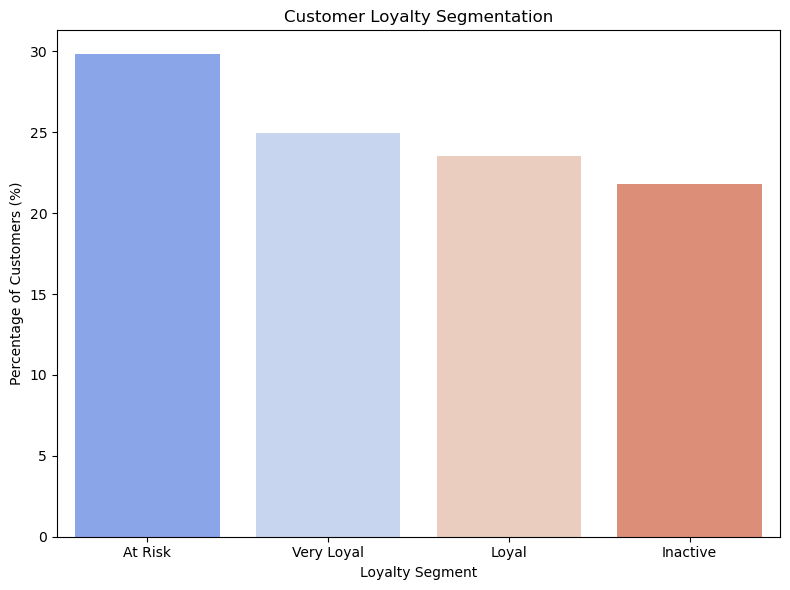

loyalty_segment
At Risk       29.806714
Very Loyal    24.923703
Loyal         23.499491
Inactive      21.770092
Name: proportion, dtype: float64


In [34]:
# Calculate the percentage of users in each loyalty segment
loyalty_distribution = customer_metrics['loyalty_segment'].value_counts(normalize=True) * 100

# Bar plot for loyalty distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=loyalty_distribution.index, y=loyalty_distribution.values, palette='coolwarm')
plt.title('Customer Loyalty Segmentation')
plt.xlabel('Loyalty Segment')
plt.ylabel('Percentage of Customers (%)')
plt.tight_layout()
plt.savefig(output_dir / 'customer_loyalty_segmentation.png')
plt.show()

# Display the distribution for a quick look
print(loyalty_distribution)

### Total Spending per Loyalty Segment

Total Spending by Loyalty Segment:
loyalty_segment
At Risk       10151557.01
Inactive      14408907.78
Loyal         25954415.08
Very Loyal    40707549.03
Name: total_spend, dtype: float64


/var/folders/x3/vr0xk6j11ll6hgm_xsz_5cn00000gn/T/ipykernel_136/315137206.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=spending_per_segment.index, y=spending_per_segment.values, palette='viridis')


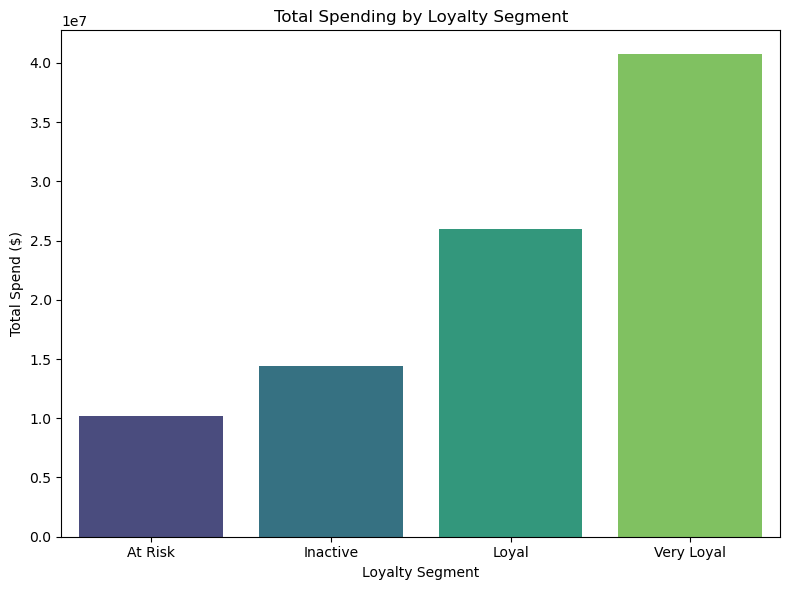

In [36]:
# Calculate the total spending by each loyalty segment
spending_per_segment = customer_metrics.groupby('loyalty_segment')['total_spend'].sum()

# Display the spending per loyalty segment
print("Total Spending by Loyalty Segment:")
print(spending_per_segment)

# Bar plot for spending by loyalty segment
plt.figure(figsize=(8, 6))
sns.barplot(x=spending_per_segment.index, y=spending_per_segment.values, palette='viridis')
plt.title('Total Spending by Loyalty Segment')
plt.xlabel('Loyalty Segment')
plt.ylabel('Total Spend ($)')
plt.tight_layout()
plt.savefig(output_dir / 'total_spending_by_loyalty_segment.png')
plt.show()

## Loyalty by State - Bar Chart

/var/folders/x3/vr0xk6j11ll6hgm_xsz_5cn00000gn/T/ipykernel_136/1133345670.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=loyalty_by_state_sorted.index, y=loyalty_by_state_sorted['loyalty_score'], palette='viridis')


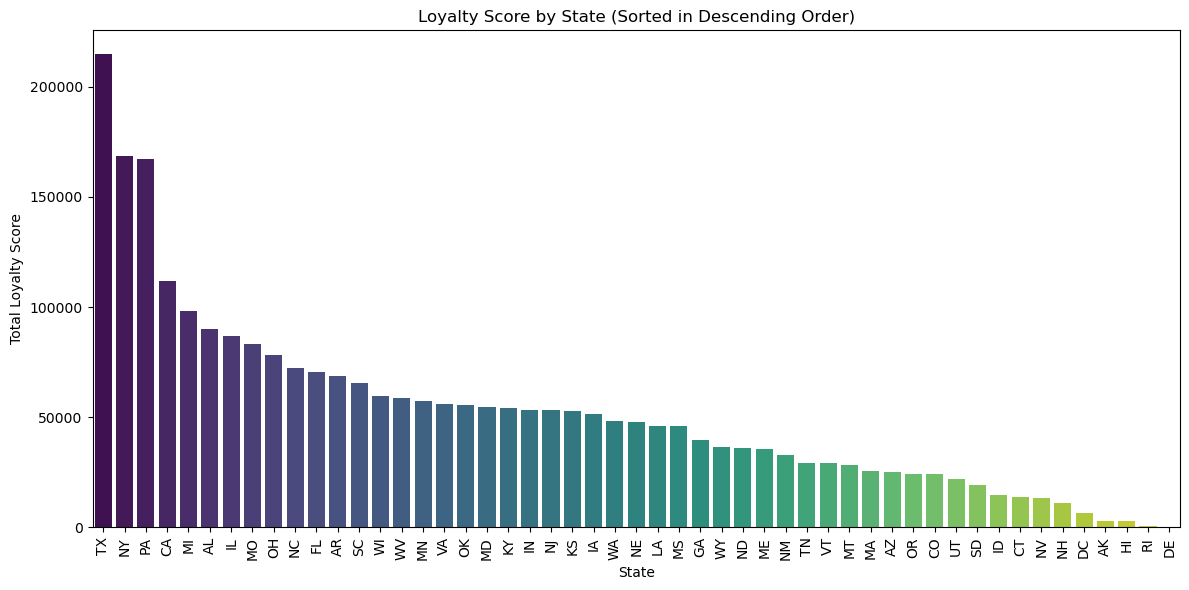

In [37]:
# Step 1: Merge loyalty data with the original dataset to retain state information
# Assume that 'customer_metrics' contains the 'cc_num' and 'loyalty_segment'
# and 'ak_df_cleaned' contains 'cc_num' and 'state'
loyalty_state_data = pd.merge(
    customer_metrics[['cc_num', 'loyalty_segment']],
    ak_df_cleaned[['cc_num', 'state']],
    on='cc_num',
    how='left'
)

# Step 2: Group by state and loyalty segment to count the number of customers in each segment per state
loyalty_by_state = loyalty_state_data.groupby(['state', 'loyalty_segment'])['cc_num'].count().unstack(fill_value=0)

# Step 3: Calculate a total loyalty score for each state by assigning weights to each segment
# (e.g., Very Loyal = 3, Loyal = 2, At Risk = 1, Inactive = 0)
loyalty_weights = {'Very Loyal': 3, 'Loyal': 2, 'At Risk': 1, 'Inactive': 0}
loyalty_by_state['loyalty_score'] = (
    loyalty_by_state['Very Loyal'] * loyalty_weights['Very Loyal'] +
    loyalty_by_state['Loyal'] * loyalty_weights['Loyal'] +
    loyalty_by_state['At Risk'] * loyalty_weights['At Risk'] +
    loyalty_by_state['Inactive'] * loyalty_weights['Inactive']
)

# Step 4: Sort the states by loyalty score in descending order
loyalty_by_state_sorted = loyalty_by_state.sort_values('loyalty_score', ascending=False)

# Step 5: Create a bar plot for loyalty scores by state
plt.figure(figsize=(12, 6))
sns.barplot(x=loyalty_by_state_sorted.index, y=loyalty_by_state_sorted['loyalty_score'], palette='viridis')
plt.title('Loyalty Score by State (Sorted in Descending Order)')
plt.xlabel('State')
plt.ylabel('Total Loyalty Score')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(output_dir / 'loyalty_by_state.png')
plt.show()

## Loyalty by State - Map

In [42]:
# Reset the index to have the 'state' column available for merging
state_loyalty_data = loyalty_by_state[['loyalty_score']].reset_index()

In [43]:
# Load the USA shapefile for states (make sure you have the correct path)
# make sure that all the downloaded files are in the folder
usa_map = gpd.read_file('Resources/cb_2021_us_state_5m.shp')

# Filter out Alaska and Hawaii for better visualization of the contiguous US
contiguous_us = usa_map[~usa_map['STUSPS'].isin(['AK', 'HI'])]

# Merge the shapefile with the loyalty data on the state abbreviation
# Assuming 'STUSPS' in the shapefile contains state abbreviations (like TX, CA)
contiguous_us = contiguous_us.merge(state_loyalty_data, left_on='STUSPS', right_on='state', how='left')

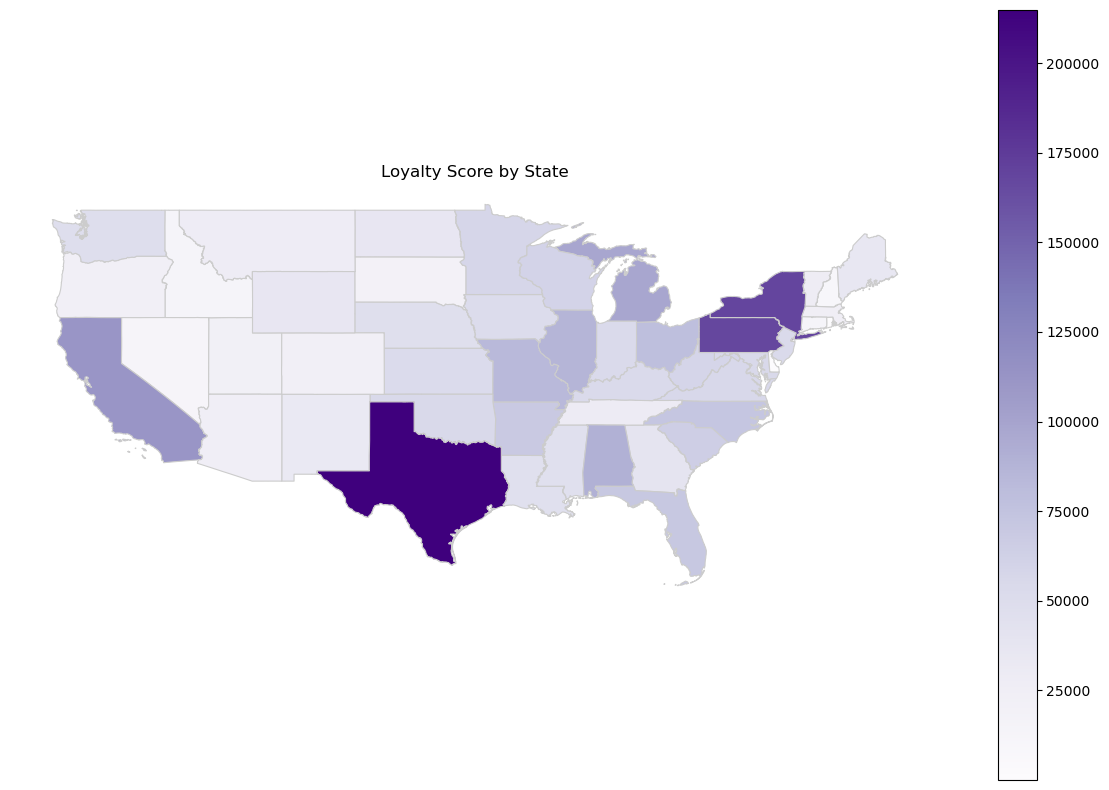

In [44]:
# Plot the map with loyalty scores
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
contiguous_us.plot(
    column='loyalty_score',
    cmap='Purples',  # Change color gradient as needed
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True
)

# Add titles and labels
ax.set_title('Loyalty Score by State')
ax.set_axis_off()  # Hide the axis for a cleaner map look

plt.savefig(output_dir / 'loyalty_by_state-map.png')
# Show the plot
plt.show()

## Loyalty by Age Group

In [45]:
# Ensure age_group is included by merging with ak_df_cleaned on 'cc_num'
customer_data_with_age = pd.merge(
    customer_metrics, 
    ak_df_cleaned[['cc_num', 'age_group']], 
    on='cc_num', 
    how='left'
)

In [46]:
# Group by 'age_group' and 'loyalty_segment' and count the number of customers in each group
age_loyalty_data = customer_data_with_age.groupby(['age_group', 'loyalty_segment']).size().unstack(fill_value=0)

# Display the resulting DataFrame for verification
print(age_loyalty_data.head())

loyalty_segment  At Risk  Inactive  Loyal  Very Loyal
age_group                                            
19-28              17635     17608  37368      109155
29-38              24871     34127  71610      170335
39-48              15423     25212  71672      187854
49-58              29261     48023  82263       40864
59-68              20468     41269  34425       47611


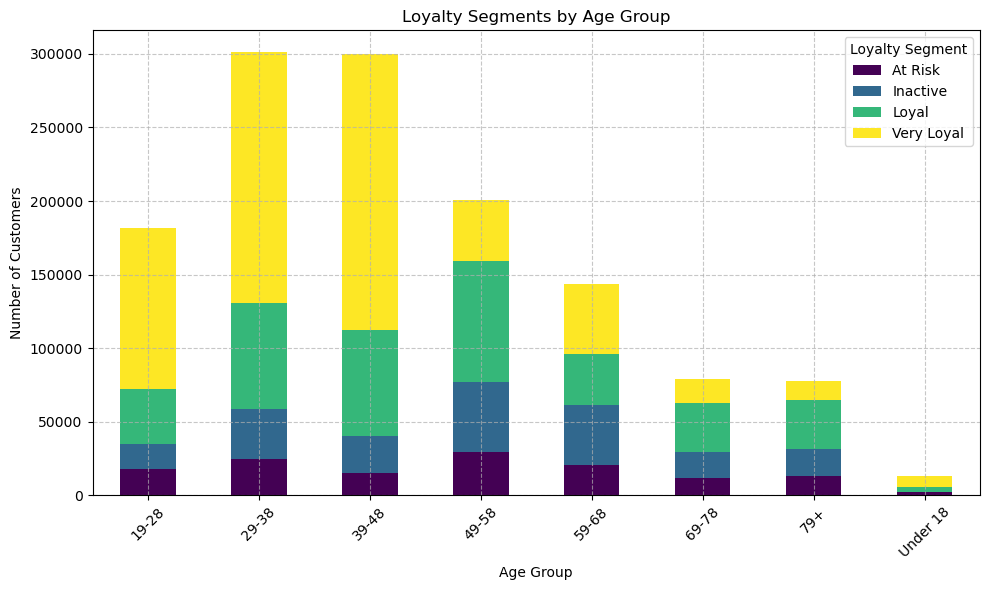

In [47]:
# Plot the data using a stacked bar chart
plt.figure(figsize=(10, 6))
age_loyalty_data.plot(
    kind='bar', 
    stacked=True, 
    colormap='viridis',  # Use a color map of your choice
    ax=plt.gca()
)

# Set plot title and labels
plt.title('Loyalty Segments by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()

# Show legend and plot
plt.legend(title='Loyalty Segment')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig(output_dir / 'loyalty_by_age_group.png')
plt.show()

## Loyalty by Job Category

In [48]:
# Ensure job_category is included by merging with ak_df_cleaned on 'cc_num'
customer_data_with_job = pd.merge(
    customer_metrics, 
    ak_df_cleaned[['cc_num', 'job_category']], 
    on='cc_num', 
    how='left'
)

# Filter out the 'Miscellaneous' job category
customer_data_with_job = customer_data_with_job[customer_data_with_job['job_category'] != 'Miscellaneous']

In [49]:
# Group by 'job_category' and 'loyalty_segment' and count the number of customers in each group
job_loyalty_data = customer_data_with_job.groupby(['job_category', 'loyalty_segment']).size().unstack(fill_value=0)

# Display the resulting DataFrame for verification
print(job_loyalty_data.head())

loyalty_segment              At Risk  Inactive  Loyal  Very Loyal
job_category                                                     
Arts & Culture                  1530      1028   4591        9248
Chemistry & Pharmaceuticals     1006      1020   5124           0
Construction & Architecture     1545      1035      0       12294
Creative & Design                534      1040   6135           0
Education & Training            3004      2037  10502        7672


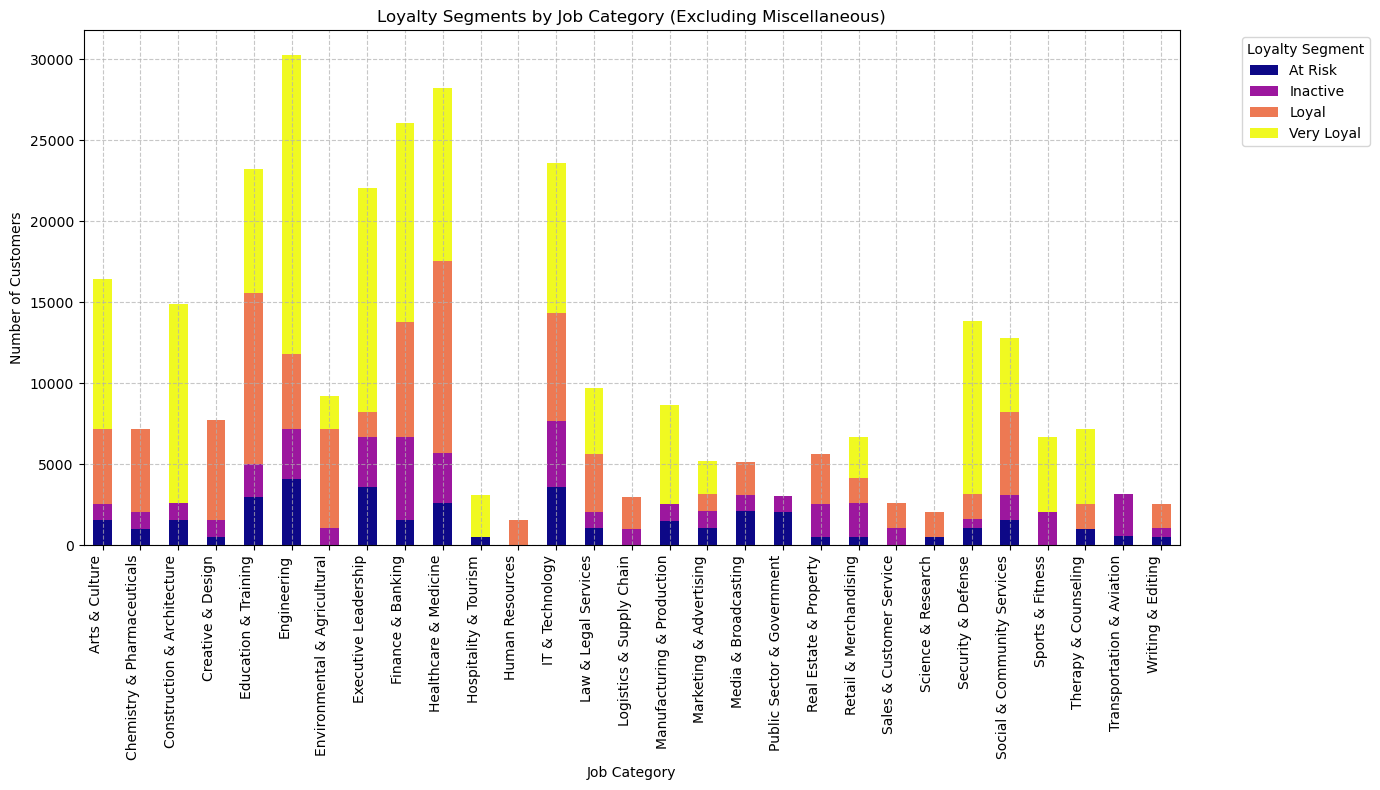

In [50]:
# Plot the data using a stacked bar chart
plt.figure(figsize=(12, 8))
job_loyalty_data.plot(
    kind='bar', 
    stacked=True, 
    colormap='plasma',  # Use a color map of your choice
    ax=plt.gca()
)

# Set plot title and labels
plt.title('Loyalty Segments by Job Category (Excluding Miscellaneous)')
plt.xlabel('Job Category')
plt.ylabel('Number of Customers')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()

# Show legend and plot
plt.legend(title='Loyalty Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig(output_dir / 'loyalty_by_job_category.png')
plt.show()